In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [4]:
from platform import python_version

print(python_version())

3.9.10


In [5]:
cred_df = pd.read_csv('Data/credit_applications.csv', sep=";")
cust_df = pd.read_csv('Data/customers.csv', sep=";")

## 1. Data Preparation

In [6]:
cred_df = cred_df.rename(columns={"Unnamed: 0": "row_nr"})
cust_df = cust_df.rename(columns={"Unnamed: 0": "row_nr"})

In [7]:
cred_df['yearmonth2'] = pd.to_datetime(cred_df['yearmonth'].astype(str), format='%Y%m')
cust_df['yearmonth2'] = pd.to_datetime(cust_df['yearmonth'].astype(str), format='%Y%m')

In [8]:
cred_df.head(10)

,row_nr,client_nr,yearmonth,credit_application,nr_credit_applications,yearmonth2
0,1,1,201401,0,0,2014-01-01
1,2,1,201402,0,0,2014-02-01
2,3,1,201403,0,0,2014-03-01
3,4,1,201404,0,0,2014-04-01
4,5,1,201405,0,0,2014-05-01
5,6,1,201406,0,0,2014-06-01
6,7,1,201407,0,0,2014-07-01
7,8,1,201408,0,0,2014-08-01
8,9,1,201409,0,0,2014-09-01
9,10,1,201410,0,0,2014-10-01


In [9]:
cust_df.head(10)

,row_nr,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,yearmonth2
0,1,1,201401,97,50,6527929,47,7454863,-7914288,25110651,1.0,2014-01-01
1,2,1,201402,88,59,3475918,29,1895848,-8448513,25036651,1.0,2014-02-01
2,3,1,201403,96,62,31316405,34,20083583,-10347650,18020151,1.0,2014-03-01
3,4,1,201404,83,53,18669967,30,1091295,-15385039,13318200,1.0,2014-04-01
4,5,1,201405,94,54,2893905,40,2034075,-15682170,2350000,1.0,2014-05-01
5,6,1,201406,74,51,2083142,23,3241073,-15927514,2000000,1.0,2014-06-01
6,7,1,201407,76,59,2538771,17,4564281,-15823639,2005161,1.0,2014-07-01
7,8,1,201408,62,40,2620143,22,4280647,-14468191,1750000,1.0,2014-08-01
8,9,1,201409,90,49,2500177,41,8339304,-12025540,1600000,1.0,2014-09-01
9,10,1,201410,112,68,5848714,44,17013661,-7211508,7819451,1.0,2014-10-01


In [10]:
merge_df = pd.merge(cust_df, cred_df, on=['client_nr', 'yearmonth2'], how='inner').drop(['row_nr_x', 'yearmonth_x', 'row_nr_y','yearmonth_y'], axis=1)

In [11]:
merge_df.head(10)

,client_nr,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,yearmonth2,credit_application,nr_credit_applications
0,1,97,50,6527929,47,7454863,-7914288,25110651,1.0,2014-01-01,0,0
1,1,88,59,3475918,29,1895848,-8448513,25036651,1.0,2014-02-01,0,0
2,1,96,62,31316405,34,20083583,-10347650,18020151,1.0,2014-03-01,0,0
3,1,83,53,18669967,30,1091295,-15385039,13318200,1.0,2014-04-01,0,0
4,1,94,54,2893905,40,2034075,-15682170,2350000,1.0,2014-05-01,0,0
5,1,74,51,2083142,23,3241073,-15927514,2000000,1.0,2014-06-01,0,0
6,1,76,59,2538771,17,4564281,-15823639,2005161,1.0,2014-07-01,0,0
7,1,62,40,2620143,22,4280647,-14468191,1750000,1.0,2014-08-01,0,0
8,1,90,49,2500177,41,8339304,-12025540,1600000,1.0,2014-09-01,0,0
9,1,112,68,5848714,44,17013661,-7211508,7819451,1.0,2014-10-01,0,0


In [12]:
# merge_df.to_csv("merged_data.csv")

## 2. Exploratory Data Analysis

### 2.1 Data understanding

#### Credit application dataframe:
* “credit_application” indicates if client applies for credit (loan renewal)
* “nr_credit_applications” indicated how many times a client applied for credit in a given month 
* if credit_application = 1 then nr_credit_application in {1,2,3,4,5,7}
* if credit_application = 0 then nr_credit_application = 0
* “nr_credit_applications” indicated how many times a client applied for credit in a given month

#### Customer dataframe:
* “total_nr_txr”, “nr_debit_txr”, “nr_credit_txr”: number of transactions
* “volume_debit_trx”, “volume_credit_trx”: amount of transactions
* “CRG”: credit risk grading 
* CR grades: 
 * Superior - 1
 * Good - 2
 * Acceptable - 3
 * Marginal - 4
 * Special mention - 5
 * Sub standard - 6
 * Doubtful - 7
 * Bad & loss - 8

#### Continuous & categorical variables (explanotary)
* total_nr_trx (cont)
* nr_debit_trx (cont)
* nr_credit_trx (cont)
* volume_debit_trx (cont)
* volume_credit_trx (cont)
* min_balance (cont)
* max_balance (cont)
* yearmonth2 (datetime)
* CRG (cat)
* nr_credit_applications (cont)

#### Continuous & categorical variables (target)
* credit_application (cat)

### 2.2 Univariate Analysis

In [13]:
merge_df.describe()

,client_nr,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,nr_credit_applications
count,29996.000000,29996.000000,29996.000000,2.999600e+04,29996.000000,2.999600e+04,2.999600e+04,2.999600e+04,24459.000000,29996.000000,29996.000000
mean,481.560775,166.427957,75.785571,1.121290e+07,90.642386,1.126906e+07,-5.523773e+06,3.752693e+06,3.251850,0.067509,0.087078
std,281.317753,220.947519,60.063496,1.617596e+07,192.244770,1.624998e+07,1.357517e+07,1.616937e+07,1.889136,0.250906,0.364473
min,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-2.485206e+08,1.000000,0.000000,0.000000
25%,237.000000,76.000000,38.000000,3.072750e+06,33.000000,3.148068e+06,-7.895864e+06,-1.868002e+06,2.000000,0.000000,0.000000
50%,479.000000,129.000000,66.000000,6.822769e+06,56.000000,6.934694e+06,-2.957198e+06,1.040998e+06,3.000000,0.000000,0.000000
75%,721.000000,205.000000,101.000000,1.386656e+07,102.000000,1.394257e+07,1.690275e+04,5.806224e+06,4.000000,0.000000,0.000000
max,1000.000000,6341.000000,1590.000000,7.980480e+08,6325.000000,8.775321e+08,2.109783e+08,3.722319e+08,7.000000,1.000000,7.000000


In [14]:
merge_df.isnull().sum()

client_nr                    0
total_nr_trx                 0
nr_debit_trx                 0
volume_debit_trx             0
nr_credit_trx                0
volume_credit_trx            0
min_balance                  0
max_balance                  0
CRG                       5537
yearmonth2                   0
credit_application           0
nr_credit_applications       0
dtype: int64

In [15]:
merge_df.dtypes

client_nr                          int64
total_nr_trx                       int64
nr_debit_trx                       int64
volume_debit_trx                   int64
nr_credit_trx                      int64
volume_credit_trx                  int64
min_balance                        int64
max_balance                        int64
CRG                              float64
yearmonth2                datetime64[ns]
credit_application                 int64
nr_credit_applications             int64
dtype: object

<AxesSubplot:xlabel='nr_credit_applications', ylabel='Count'>

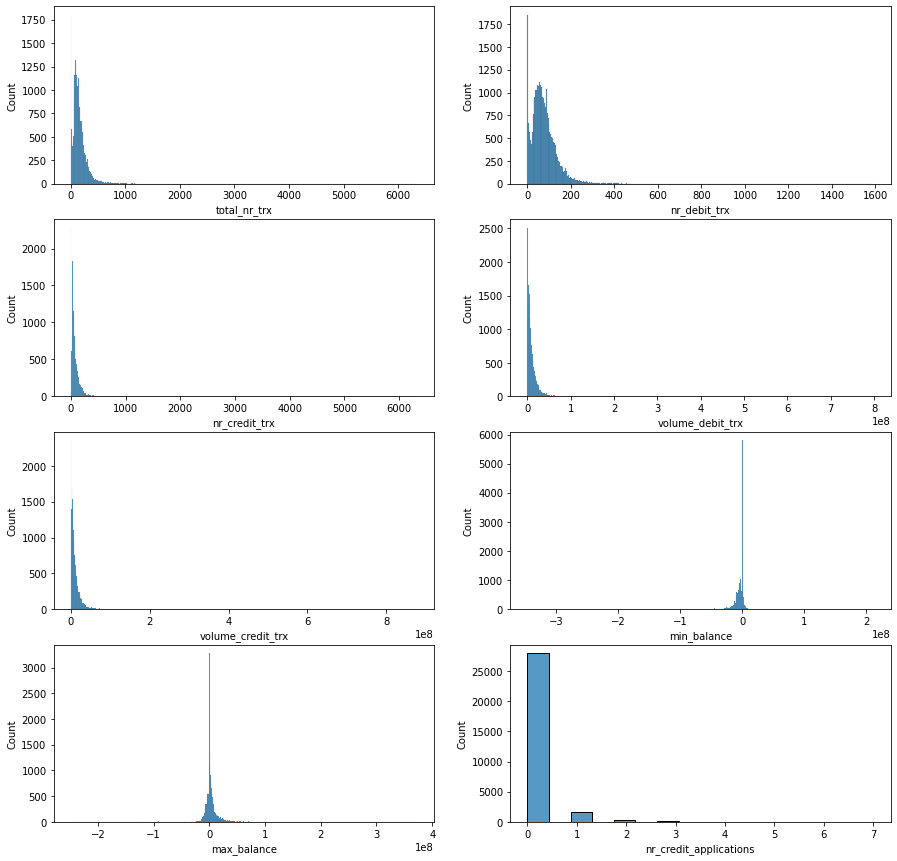

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
sns.histplot(ax=ax[0,0], x='total_nr_trx', data=merge_df)
sns.histplot(ax=ax[0,1], x='nr_debit_trx', data=merge_df)
sns.histplot(ax=ax[1,0], x='nr_credit_trx', data=merge_df)
sns.histplot(ax=ax[1,1], x='volume_debit_trx', data=merge_df)
sns.histplot(ax=ax[2,0], x='volume_credit_trx', data=merge_df)
sns.histplot(ax=ax[2,1], x='min_balance', data=merge_df)
sns.histplot(ax=ax[3,0], x='max_balance', data=merge_df)
sns.histplot(ax=ax[3,1], x='nr_credit_applications', data=merge_df)

<AxesSubplot:>

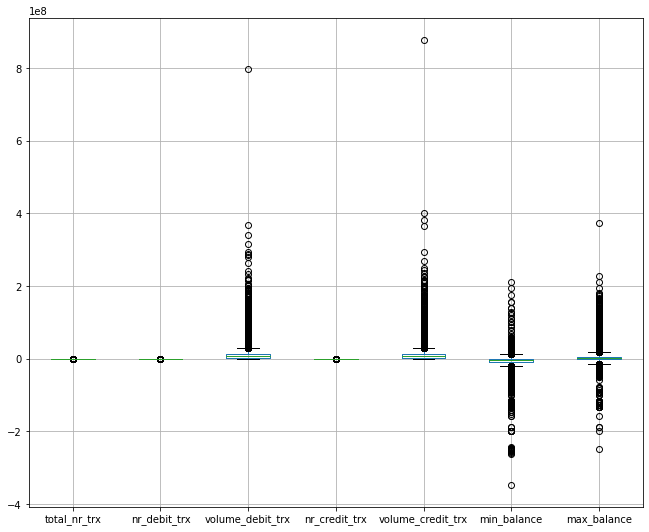

In [17]:
sub_df1 = merge_df[['total_nr_trx', 'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx', 'volume_credit_trx', 
                    'min_balance', 'max_balance']]
f, ax = plt.subplots(figsize=(11, 9))
sub_df1.boxplot()

In [18]:
def iqr_outlier_detect(var, data):
    Q1 = np.percentile(data[var], 25, interpolation='midpoint')
    Q3 = np.percentile(data[var], 75, interpolation='midpoint')
    IQR = Q3 - Q1
    lf = Q1 - 1.5*IQR
    uf = Q3 + 1.5*IQR
    outl_lf = len(data[data[var] < lf])
    outl_uf = len(data[data[var] > uf])

    print("Total number of outliers in {}: {}({},{})".format(var, outl_lf+outl_uf, outl_lf, outl_uf) )

In [19]:
var_list = ['total_nr_trx', 'nr_debit_trx', 'nr_credit_trx', 'volume_debit_trx', 'volume_credit_trx', 'min_balance',
           'max_balance', 'nr_credit_applications']

for var in var_list:
    iqr_outlier_detect(var, merge_df) 
    print("\n")

Total number of outliers in total_nr_trx: 1474(0,1474)


Total number of outliers in nr_debit_trx: 1043(0,1043)


Total number of outliers in nr_credit_trx: 2153(0,2153)


Total number of outliers in volume_debit_trx: 2011(0,2011)


Total number of outliers in volume_credit_trx: 2054(0,2054)


Total number of outliers in min_balance: 2170(1877,293)


Total number of outliers in max_balance: 3589(803,2786)


Total number of outliers in nr_credit_applications: 2025(0,2025)




/var/folders/fg/rbnh6s990114df6hzsrg0mhc0000gn/T/ipykernel_20159/2347369677.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(data[var], 25, interpolation='midpoint')
/var/folders/fg/rbnh6s990114df6hzsrg0mhc0000gn/T/ipykernel_20159/2347369677.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(data[var], 75, interpolation='midpoint')


### 2.3 Bivariate Analysis

<AxesSubplot:ylabel='count'>

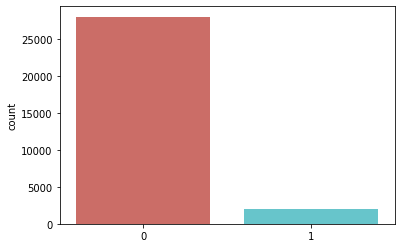

In [20]:
sns.countplot(x=merge_df['credit_application'].values, data=merge_df, palette='hls')

<AxesSubplot:ylabel='count'>

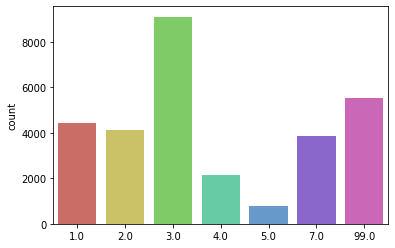

In [21]:
temp = merge_df.copy()
temp["CRG"] = temp["CRG"].fillna(99)
sns.countplot(x=temp['CRG'].values, data=temp, palette='hls')

In [22]:
print("% of consumers applied for credit: ",(len(merge_df[merge_df['credit_application']==1]['credit_application'])/len(merge_df))*100)
print("% of consumers did not apply for credit: ",(len(merge_df[merge_df['credit_application']==0]['credit_application'])/len(merge_df))*100)

% of consumers applied for credit:  6.750900120016003
% of consumers did not apply for credit:  93.249099879984


Text(0, 0.5, 'count')

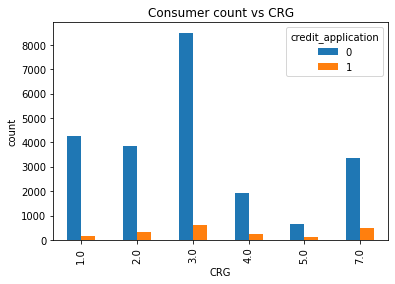

In [23]:
%matplotlib inline
pd.crosstab(merge_df['CRG'], merge_df['credit_application']).plot(kind='bar')
plt.title('Consumer count vs CRG')
plt.xlabel('CRG')
plt.ylabel('count')

In [24]:
merge_df.head()

,client_nr,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,yearmonth2,credit_application,nr_credit_applications
0,1,97,50,6527929,47,7454863,-7914288,25110651,1.0,2014-01-01,0,0
1,1,88,59,3475918,29,1895848,-8448513,25036651,1.0,2014-02-01,0,0
2,1,96,62,31316405,34,20083583,-10347650,18020151,1.0,2014-03-01,0,0
3,1,83,53,18669967,30,1091295,-15385039,13318200,1.0,2014-04-01,0,0
4,1,94,54,2893905,40,2034075,-15682170,2350000,1.0,2014-05-01,0,0


<AxesSubplot:>

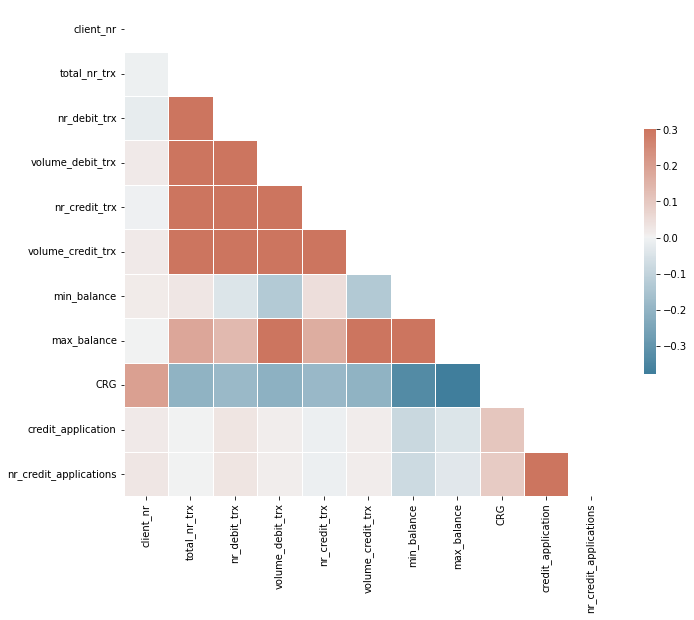

In [25]:
# temp = merge_df.drop("yearmonth2", axis=1)

# Compute the correlation matrix
corr = merge_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Observations:
* Highly imbalanced target variable
* Outliers present in all continuous variables based on IQR method
* Dataset contains highest number of consumers with CRG=3
* CRG might be good predictor for the outcome variable
* credit application & min/max_balance: negative correlation
* credit application & CRG: positive correlation
* CRG: Has negative correlation with almost all variables
* Positive correlation between number and volume of transactions (obvious)
* Positive correlation between credit application & number of credit application (obvious)